<a href="https://colab.research.google.com/github/allesid/NN_learning/blob/main/module05_mnist_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets

In [3]:
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)


In [4]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:59: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [5]:
len(y_train), len(y_test)

(60000, 10000)

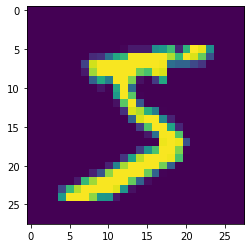

tensor(5)


In [6]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [7]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [8]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [9]:
class LeNet5(torch.nn.Module):
    def __init__(self, inp_dat_sz, 
                 ks_c1=5, st_c1=1, pd_c1=2, och_c1=6,
                 ks_p1=2, st_p1=2, pd_p1=0, 
                 ks_c2=5, st_c2=1, pd_c2=0, och_c2=16,
                 ks_p2=2, st_p2=2, pd_p2=0
                 ):
        super(LeNet5, self).__init__()
        self.inp_dat_sz = inp_dat_sz
        self.ks_c1 = ks_c1
        self.st_c1 = st_c1
        self.pd_c1 = pd_c1
        self.och_c1 = och_c1
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=self.och_c1, kernel_size=self.ks_c1, 
            stride=self.st_c1, padding=self.pd_c1)
        self.xsz = (self.inp_dat_sz - self.ks_c1 + 2*self.pd_c1)//self.st_c1 + 1
        #print('self.xsz=',self.xsz)
        self.act1  = torch.nn.Tanh()

        #self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.ks_p1 = ks_p1
        self.st_p1 = st_p1
        self.pd_p1 = pd_p1
        self.pool1 = torch.nn.AvgPool2d(kernel_size=self.ks_p1, 
                                        stride=self.st_p1, padding=self.pd_p1)
        #self.pool1 = torch.nn.FractionalMaxPool2d(kernel_size=3, output_size=14)
        self.xsz1 = (self.xsz - self.ks_p1 + 2*self.pd_p1)//self.st_p1 + 1
        #print('self.xsz=',self.xsz)
        
        self.ks_c2 = ks_c2
        self.st_c2 = st_c2
        self.pd_c2 = pd_c2
        self.och_c2 = och_c2
        self.xsz2 = (self.xsz1 - self.ks_c2 + 2*self.pd_c2)//self.st_c2 + 1
        self.conv2 = torch.nn.Conv2d(
            in_channels=self.och_c1, out_channels=self.och_c2, 
            kernel_size=self.ks_c2, stride=self.st_c2, padding=self.pd_c2)
        #print('self.xsz=',self.xsz)
        self.act2  = torch.nn.Tanh()


        self.ks_p2 = ks_p2
        self.st_p2 = st_p2
        self.pd_p2 = pd_p2
        self.pool2 = torch.nn.AvgPool2d(kernel_size=self.ks_p2, 
                                        stride=self.st_p2, padding=self.pd_p2)
        #self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        #self.pool2 = torch.nn.FractionalMaxPool2d(kernel_size=3, output_size=(1,120))
        self.xsz3 = (self.xsz2 - self.ks_p2 + 2*self.pd_p2)//self.st_p2 + 1
        self.fc1   = torch.nn.Linear(self.och_c2 * self.xsz3 * self.xsz3, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
    def forward_print(self, x):
        print('x.shape=',x.shape)
        x = self.conv1(x)
        print('x conv1=',x.shape)
        #print('x 0=',x[0,0])
        #print('x 1=',x[0,1])
        #print('x 2=',x[0,2])
        #print('x 3=',x[0,3])
        #print('x 4=',x[0,4])
        #print('x 5=',x[0,5])
        x = self.act1(x)
        print('x act1=',x.shape)
        x = self.pool1(x)
        print('x pool1=',x.shape)
        x = self.conv2(x)
        print('x conv2=',x.shape)
        x = self.act2(x)
        print('x act2=',x.shape)
        x = self.pool2(x)
        print('x pool2=',x.shape)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        print('x view=',x.shape)

        x = self.fc1(x)
        print('x fc1=',x.shape)
        x = self.act3(x)
        print('x act3=',x.shape)
        x = self.fc2(x)
        print('x fc2=',x.shape)
        x = self.act4(x)
        print('x act4=',x.shape)
        x = self.fc3(x)
        print('x fc3=',x.shape)
        
        return x
    

In [10]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#lenet5 = lenet5.to(device)

In [11]:
#loss = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)
#optimizer = torch.optim.SGD(lenet5.parameters(), lr=0.5)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

batch_size = 10000

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

"""
                 ks_c1=5, st_c1=1, pd_c1=2, och_c1=6,
                 ks_p1=2, st_p1=2, pd_p1=0, 
                 ks_c2=5, st_c2=1, pd_c2=0, och_c2=16,
                 ks_p2=2, st_p2=2, pd_p2=0

lenet5 = LeNet5(28,
                5,1,2,6,
                3,2,0,
                5,1,0,16,
                2,2,0)  
ks_c2=5
st_c2=1
pd_c2=0
och_c2=16
ks_p2=2
st_p2=2
pd_p2=0
for och_c1 in [2,3,4,5,6,7,8]:
  for ks_c1 in [2,3,4,5,6,7,8]:
    for st_c1 in [2,3,4]:
      if st_c1 > ks_c1:
        continue
      for pd_c1 in [0,1,2,3,4]:
        if pd_c1 > ks_c1//2:
          continue 
        for ks_p1 in [2,3,4,5]:
          for st_p1 in [1,2,3,4]:
            if st_p1 != ks_p1:
              continue
            for pd_p1 in [0,1,2,3,4]:
              if pd_p1 > ks_p1//2:
                continue
"""
ks_c1=5
st_c1=1
pd_c1=2
och_c1=6
ks_p1=2
st_p1=2
pd_p1=0
inp_dat_sz = 28
accuracy_max = 0
for och_c2 in [12,14,16,18,20]:
  for ks_c2 in [2,3,4,5,6,7,8]:
    for st_c2 in [1,2,3,4,5]:
      if st_c2 > ks_c2:
        continue
      for pd_c2 in [0,1,2,3,4]:
        if pd_c2 > ks_c2//2:
          continue 
        for ks_p2 in [2,3,4,5]:
          for st_p2 in [1,2,3,4]:
            if st_p2 > ks_p2:
              continue
            for pd_p2 in [0,1,2,3,4]:
              if pd_p2 > ks_p2//2:
                continue
              xsz = (inp_dat_sz - ks_c1 + 2*pd_c1)//st_c1 + 1
              xsz1 = (xsz - ks_p1 + 2*pd_p1)//st_p1 + 1
              xsz2 = (xsz1 - ks_c2 + 2*pd_c2)//st_c2 + 1
              xsz3 = (xsz2 - ks_p2 + 2*pd_p2)//st_p2 + 1
              if xsz2<=0 or xsz3<=0 or xsz<=0 or xsz1<=0:
                continue
              print('\t',' xsz=',xsz,xsz1,xsz2,xsz3)
              
              lenet5 = LeNet5(inp_dat_sz,
                              ks_c1,st_c1,pd_c1,och_c1,
                              ks_p1,st_p1,pd_p1,
                              ks_c2, st_c2, pd_c2, och_c2,
                              ks_p2, st_p2, pd_p2
                              )  
              lenet5 = lenet5.to(device)              
              loss = torch.nn.CrossEntropyLoss()
              optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)
              for epoch in range(150):
                  order = np.random.permutation(len(X_train))
                  for start_index in range(0, len(X_train), batch_size):
                      optimizer.zero_grad()
                      
                      batch_indexes = order[start_index:start_index+batch_size]
                      
                      X_batch = X_train[batch_indexes].to(device)
                      y_batch = y_train[batch_indexes].to(device)
                      
                      preds = lenet5.forward(X_batch) 
                      
                      loss_value = loss(preds, y_batch)
                      loss_value.backward()
                      
                      optimizer.step()
                      #scheduler.step()
                      
              test_preds = lenet5.forward(X_test)
              test_loss_history.append(loss(test_preds, y_test).data.cpu())

              accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
              test_accuracy_history.append(accuracy)
              #print('\t',accuracy, ks_c1,st_c1,pd_c1,och_c1,ks_p1,st_p1,pd_p1)
              print('\t',accuracy, ks_c2,st_c2,pd_c2,och_c2,ks_p2,st_p2,pd_p2)
              if accuracy > accuracy_max:
                accuracy_max = accuracy
                #print('MAX=',accuracy, ks_c1,st_c1,pd_c1,och_c1,ks_p1,st_p1,pd_p1)
                print('MAX=',accuracy, ks_c2,st_c2,pd_c2,och_c2,ks_p2,st_p2,pd_p2)


	  xsz= 28 14 13 12


lenet5.forward(X_test)

In [ ]:
plt.plot(test_accuracy_history);
#plt.plot(test_loss_history);